**Сравнительный анализ методов активного обучения**

В данном проекте мы реализуем и сравним эффективность трёх алгоритмов активного обучения — Coreset, Least Confidence (LC) и BALD — на датасете MNIST с использованием библиотеки Keras.

# 1. Подготовка данных и модели

## 1.1. Выбор датасета

Мы используем стандартный датасет MNIST, содержащий 70,000 изображений рукописных цифр (60,000 для обучения и 10,000 для тестирования). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
# Для алгоритма Coreset
from scipy.spatial.distance import cdist

# Установка случайного сида для воспроизводимости
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Грузим датасета MNIST
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

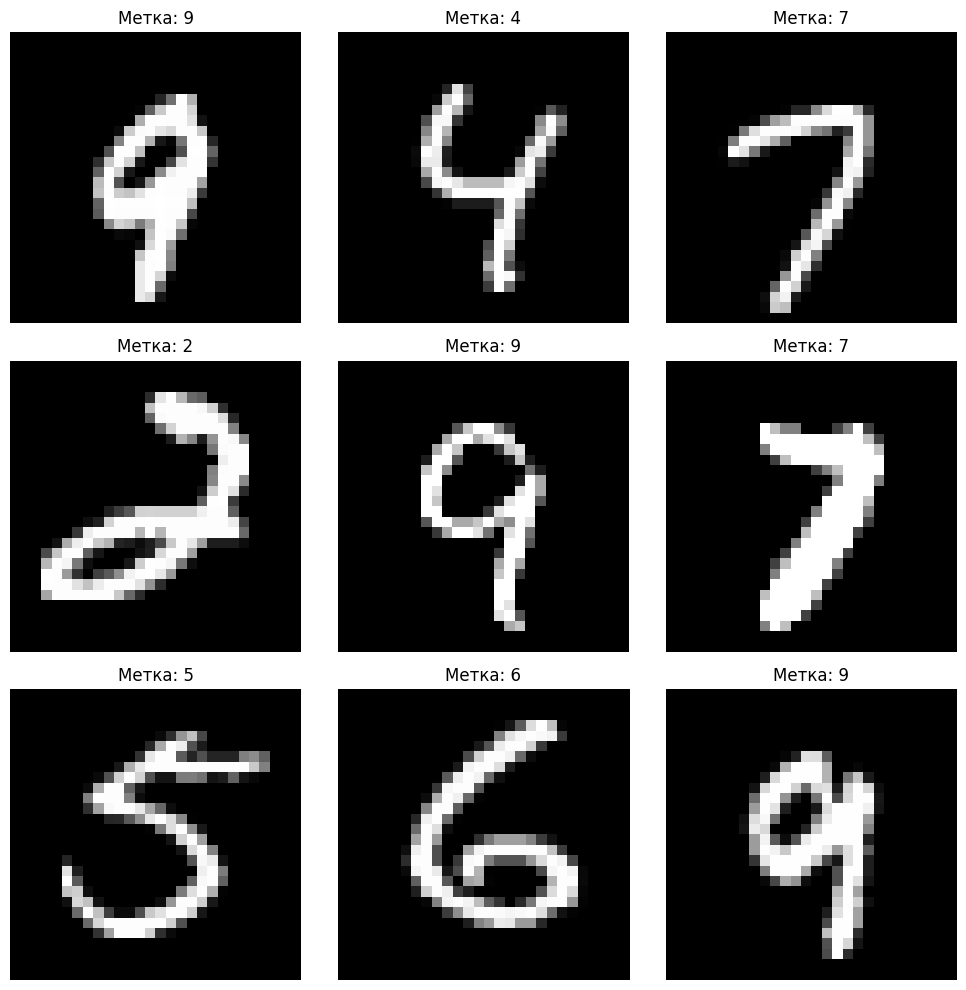

In [ ]:
def visualize_samples(X, y, num_samples=9):
    """
    Функция для визуализации.

    Параметры:
    - X: numpy.ndarray, массив изображений
    - y: numpy.ndarray, массив меток
    - num_samples: int, количество отображаемых примеров (по умолчанию 9)
    """
    # Выбор случайных индексов
    indices = random.sample(range(len(X)), num_samples)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1) 
        plt.imshow(X[idx], cmap='gray')  
        plt.title(f"Метка: {y[idx]}") 
        plt.axis('off') 

    plt.tight_layout()
    plt.show()


visualize_samples(X_train_full, y_train_full, num_samples=9)

Выполним:
1. Нормализация данных - приведем значения пикселей к диапазону [0, 1] для ускорения и стабилизации процесса обучения модели.

2. Разделение на обучающую и тестовую выборки. 

3. Визуализация данных.

In [3]:
# Нормализация данных
X_train_full = X_train_full.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Добавление канального измерения (для Keras)
X_train_full = np.expand_dims(X_train_full, -1)
X_test = np.expand_dims(X_test, -1)

# Преобразование меток в one-hot encoding
y_train_full_cat = to_categorical(y_train_full, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

## 1.2. Разделение датасета

Датасет MNIST разделяется на обучающую и тестовую выборки случайным образом. Кроме того, из обучающей выборки выделяется валидационная подвыборка для мониторинга процесса обучения модели.

In [ ]:
# Разделение обучающего набора на обучающую и валидационную, 10% - для валидации
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full_cat, test_size=0.1, random_state=random_seed
)

## 1.3. Выбор и определение целевой модели

В качестве целевой модели мы используем простую сверточную нейронную сеть (CNN), реализованную с помощью Keras.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    """
    Создаёт сверточную нейронную сеть (CNN).

    Возвращает:
    - model: компилированная модель НС
    """
    model = Sequential([
        Input(shape=(28,28,1)), 
        Conv2D(32, kernel_size=(3,3), activation='relu'), 
        MaxPooling2D(pool_size=(2,2)), 
        Conv2D(64, kernel_size=(3,3), activation='relu'),  
        MaxPooling2D(pool_size=(2,2)), 
        Flatten(),  # Выпрямление
        Dense(128, activation='relu'),
        Dropout(0.5),  # Слой Dropout для регуляризации
        Dense(10, activation='softmax') 
    ])

    # Компиляция модели
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
model = create_model()


## 1.4. Обучение и оценка модели
### 1.4.1. Обучение на всем обучающем датасете

Модель обучается на полном объёме обучающих данных, и её производительность оценивается на тестовом наборе с использованием метрики F1-score.

### 1.4.2. Обучение на случайных подвыборках (1%, 10%, 20%)

Для оценки базового уровня производительности модели обучаем её на случайно выбранных подвыборках размером 1%, 10% и 20% от обучающего набора. Каждый эксперимент повторяется 5 раз для получения статистически устойчивых результатов.

### 1.4.3. Проверка качества обученных моделей

Качество обученных моделей оценивается на тестовом наборе с использованием метрики F1-score. Для подвыборок проводим 5 повторных экспериментов и рассчитываем среднее значение и стандартное отклонение метрики.

In [ ]:
# Функция для обучения модели и оценки F1-score
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0) 
    y_pred = model.predict(X_test)  # Предсказания на тестовом наборе
    y_pred_classes = np.argmax(y_pred, axis=1)  # Определение классов с наибольшей вероятностью
    y_true = np.argmax(y_test, axis=1)  # Истинные метки
    f1 = f1_score(y_true, y_pred_classes, average='macro')  # Вычисление F1-score
    return f1

# Обучение на полном обучающем наборе
model_full = create_model()
f1_full = train_and_evaluate(model_full, X_train, y_train, X_test, y_test_cat)
print(f"F1 на полном обучающем наборе: {f1_full:.4f}")

# Обучение на случайных подвыборках
percentages = [1, 10, 20]  # Проценты выборки
results_random = {p: [] for p in percentages}  # Словарь для хранения результатов

for p in percentages:
    sample_size = int(len(X_train) * p / 100)  # Размер выборки
    for i in range(5):  # 5 повторений
        # Случайная выборка индексов
        indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train[indices]
        y_sample = y_train[indices]

        # Создание и обучение модели
        model = create_model()
        f1 = train_and_evaluate(model, X_sample, y_sample, X_test, y_test_cat)
        results_random[p].append(f1)
    # Вывод среднего F1 и стандартного отклонения
    print(f"F1 для {p}% случайной выборки: {np.mean(results_random[p]):.4f} ± {np.std(results_random[p]):.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 на полном обучающем наборе: 0.9909
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1 для 1% случайной выборки: 0.8577 ± 0.0081
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 для 10% случайной выборки: 0.9704 ± 0.0026
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1 для 20% случайной выборки: 0.9805 ± 0.0011


Результаты обучения модели на случайных подвыборках демонстрируют значительную зависимость производительности от размера обучающего набора. Модель, обученная на полном наборе данных, достигает впечатляющего значения F1-score равного 0.99, что свидетельствует о высокой точности и способности к обобщению. При использовании лишь 1% обучающих данных (около 600 примеров) модель достигает F1-score 0.86 с относительным стандартным отклонением ±0.0081, что указывает на стабильную, хотя и более низкую производительность по сравнению с полной выборкой.

Увеличение размера обучающей подвыборки до 10% (примерно 6,000 примеров) приводит к значительному улучшению показателя F1 до 0.9704 ± 0.0026, что почти приближается к показателю полной выборки. Дальнейшее увеличение до 20% (около 12,000 примеров) обеспечивает небольшое дополнительное улучшение до 0.9805 ± 0.0011. Эти результаты демонстрируют, что даже небольшие объемы случайно выбранных данных могут обеспечить высокую производительность модели, однако использование методов активного обучения может позволить достичь аналогичных или лучших показателей с еще меньшими затратами на разметку данных.


# 2. Активное обучение

В данном разделе мы реализуем три алгоритма активного обучения — [Coreset](https://openreview.net/pdf?id=H1aIuk-RW), [Least Confidence (LC)](https://arxiv.org/pdf/cmp-lg/9407020) и [BALD](https://arxiv.org/pdf/1112.5745). Каждый алгоритм будет применён для выбора 1%, 10% и 20% данных из пула неразмеченных данных.

## 2.1. Реализация алгоритмов активного обучения

### 2.1.1. Least Confidence (LC)

Least Confidence выбирает те примеры, по которым модель наиболее неуверенна в своих предсказаниях. В многоклассовой классификации это означает выбор примеров с наименьшей максимальной вероятностью предсказанного класса.

In [9]:
# Функция для алгоритма Least Confidence (LC)
def least_confidence(model, X_pool, n_samples):
    preds = model.predict(X_pool)  # Получение предсказаний модели
    max_confidence = np.max(preds, axis=1)  # Максимальная вероятность для каждого примера
    uncertainty = 1 - max_confidence  # Степень неопределенности
    query_indices = np.argsort(uncertainty)[-n_samples:]  # Индексы least confidence примеров
    return query_indices

### 2.1.2. BALD

BALD (Bayesian Active Learning by Disagreement) оценивает неопределённость через ансамбль предсказаний, используя технику Monte Carlo Dropout. Это приближённая реализация BALD, так как полноценная реализация с гауссовскими процессами в Keras требует значительных модификаций. В данной реализации BALD энтропия используется как приближение взаимной информации.

In [10]:
# Функция для алгоритма BALD с использованием Monte Carlo Dropout
def bald(model, X_pool, n_samples, n_iterations=10):
    """
    Выбирает n_samples примеров с максимальной энтропией предсказаний модели.

    Параметры:
    - model: обученная Keras модель
    - X_pool: numpy.ndarray, пул неразмеченных данных
    - n_samples: int, количество выбираемых примеров
    - n_iterations: int, количество итераций для Monte Carlo Dropout

    Возвращает:
    - query_indices: numpy.ndarray, индексы выбранных примеров
    """
    from tensorflow.keras.models import clone_model
    from tensorflow.keras.layers import Dropout

    # Клонирование модели для включения Dropout слоев во время предсказания
    model_dropout = clone_model(model)

    # Копирование весов из оригинальной модели в клонированную
    for orig_layer, dropout_layer in zip(model.layers, model_dropout.layers):
        if len(orig_layer.get_weights()) > 0:
            dropout_layer.set_weights(orig_layer.get_weights())

    # Включение Dropout слоёв
    for layer in model_dropout.layers:
        if isinstance(layer, Dropout):
            layer.trainable = True  # Включение обучения для Dropout

    model_dropout.compile(optimizer=Adam(),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

    # Проведение нескольких предсказаний с включенным Dropout
    preds = []
    for _ in range(n_iterations):
        preds.append(model_dropout.predict(X_pool, verbose=0))
    preds = np.array(preds)  # Форма: (n_iterations, n_samples, n_classes)

    # Среднее предсказание
    mean_preds = np.mean(preds, axis=0)  # (n_samples, n_classes)

    # Энтропия средних предсказаний
    entropy = -np.sum(mean_preds * np.log(mean_preds + 1e-10), axis=1)

    # Взаимная информация (приближённо энтропия)
    mutual_info = entropy  # Для приближенной реализации

    # Выбор примеров с наибольшей энтропией
    query_indices = np.argsort(mutual_info)[-n_samples:]
    return query_indices

### 2.1.3. Coreset

Coreset выбирает подмножество данных, которое максимально покрывает пространство признаков, обеспечивая разнообразие и репрезентативность выбранных примеров. Реализуем жадный алгоритм, который выбирает точки с максимальным минимальным расстоянием до уже выбранных.

In [11]:
# Функция для алгоритма Coreset с жадным подходом
def greedy_coreset_selection(X_pool, n_samples):
    """
    Жадный алгоритм для выбора core-set, максимизирующий минимальное расстояние.

    Параметры:
    - X_pool: numpy.ndarray, пул неразмеченных данных
    - n_samples: int, количество выбираемых примеров

    Возвращает:
    - selected_indices: list, индексы выбранных примеров
    """
    selected_indices = []
    # Инициализация: случайный выбор первой точки
    first_idx = np.random.choice(len(X_pool))
    selected_indices.append(first_idx)

    # Вычисление расстояний от всех точек до выбранных
    distances = cdist([X_pool[first_idx].flatten()], X_pool.reshape(len(X_pool), -1), 'euclidean').flatten()

    for _ in range(1, n_samples):
        # Выбор точки с максимальным минимальным расстоянием до выбранных
        next_idx = np.argmax(distances)
        selected_indices.append(next_idx)

        # Обновление минимальных расстояний
        new_distances = cdist([X_pool[next_idx].flatten()], X_pool.reshape(len(X_pool), -1), 'euclidean').flatten()
        distances = np.minimum(distances, new_distances)

    return selected_indices

## 2.2. Обучение на выборках, полученных через активное обучение

Для каждого из трёх алгоритмов активного обучения и для каждого из процентных уровней выборки (1%, 10%, 20%) выполняем следующие шаги:

1. Выбор подвыборки. Используем соответствующий алгоритм для выбора наиболее информативных примеров из пула неразмеченных данных.
2. Обучение модели. Обучаем модель на выбранной подвыборке.
3. Оценка качества. Вычисляем метрику F1 на тестовом наборе.

In [12]:
# Обучение на выборках, полученных через активное обучение
results_active_lc = {p: [] for p in percentages}
results_active_bald = {p: [] for p in percentages}
results_active_coreset = {p: [] for p in percentages}

## 2.3. Оценка качества обученных моделей

Качество моделей оценивается на тестовом наборе с использованием метрики F1-score. Для каждого процентного уровня выборки выполняем 5 повторных экспериментов и рассчитываем среднее значение и стандартное отклонение метрики.

In [13]:
for p in percentages:
    sample_size = int(len(X_train) * p / 100)  # Размер выборки
    for i in range(5):  # 5 повторений
        # Копирование пула неразмеченных данных
        X_pool = X_train.copy()
        y_pool = y_train.copy()

        # Обучение модели на полном обучающем наборе
        model = create_model()
        model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)

        # Least Confidence (LC)
        lc_indices = least_confidence(model, X_pool, sample_size)
        X_lc = X_pool[lc_indices]
        y_lc = y_pool[lc_indices]

        # Обучение модели на LC выборке
        model_active_lc = create_model()
        f1_active_lc = train_and_evaluate(model_active_lc, X_lc, y_lc, X_test, y_test_cat)
        results_active_lc[p].append(f1_active_lc)

        # BALD
        bald_indices = bald(model, X_pool, sample_size)
        X_bald = X_pool[bald_indices]
        y_bald = y_pool[bald_indices]

        # Обучение модели на BALD выборке
        model_active_bald = create_model()
        f1_active_bald = train_and_evaluate(model_active_bald, X_bald, y_bald, X_test, y_test_cat)
        results_active_bald[p].append(f1_active_bald)

        # Coreset
        coreset_indices = greedy_coreset_selection(X_pool, sample_size)
        X_coreset = X_pool[coreset_indices]
        y_coreset = y_pool[coreset_indices]

        # Обучение модели на Coreset выборке
        model_active_coreset = create_model()
        f1_active_coreset = train_and_evaluate(model_active_coreset, X_coreset, y_coreset, X_test, y_test_cat)
        results_active_coreset[p].append(f1_active_coreset)

    # Вывод результатов для текущего процента
    print(f"F1 для {p}%:")
    print(f"  Случайный отбор: {np.mean(results_random[p]):.4f} ± {np.std(results_random[p]):.4f}")
    print(f"  Least Confidence (LC): {np.mean(results_active_lc[p]):.4f} ± {np.std(results_active_lc[p]):.4f}")
    print(f"  BALD: {np.mean(results_active_bald[p]):.4f} ± {np.std(results_active_bald[p]):.4f}")
    print(f"  Coreset: {np.mean(results_active_coreset[p]):.4f} ± {np.std(results_active_coreset[p]):.4f}\n")

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 для 1%:
  Случайный отбор: 0.8577 ± 0.0081
  Least Confidence (LC): 0.2989 ± 0.0704
  BALD: 0.2989 ± 0.0996
  Coreset: 0.5671 ± 0.0606

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 

# 3. Анализ результатов

## 3.1. Визуализация результатов

Для наглядного сравнения эффективности методов активного обучения и случайного отбора представим результаты в виде графика.

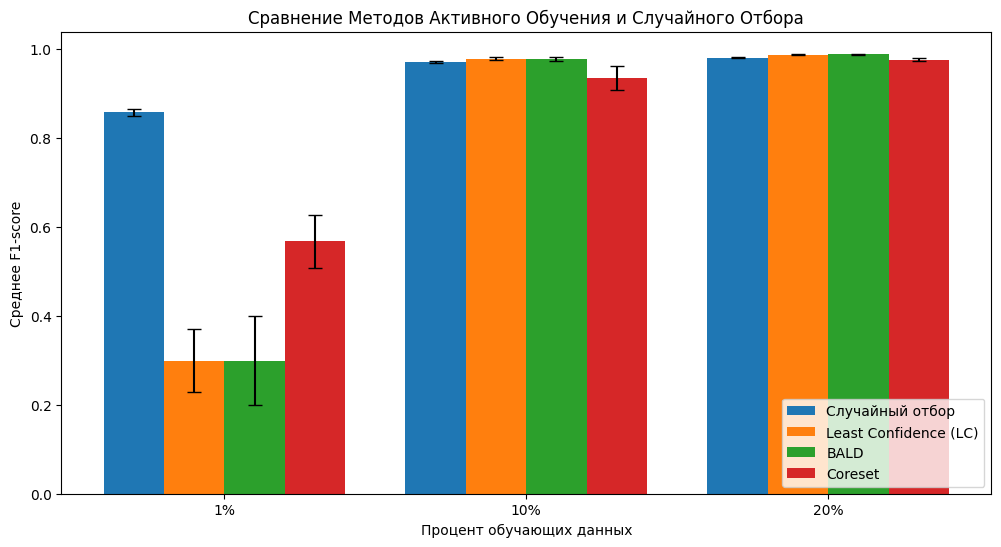

In [ ]:
# Средние значения и стандартные отклонения для случайного отбора
random_means = [np.mean(results_random[p]) for p in percentages]
random_stds = [np.std(results_random[p]) for p in percentages]

# Средние значения и стандартные отклонения для Least Confidence (LC)
lc_means = [np.mean(results_active_lc[p]) for p in percentages]
lc_stds = [np.std(results_active_lc[p]) for p in percentages]

# Средние значения и стандартные отклонения для BALD
bald_means = [np.mean(results_active_bald[p]) for p in percentages]
bald_stds = [np.std(results_active_bald[p]) for p in percentages]

# Средние значения и стандартные отклонения для Coreset
coreset_means = [np.mean(results_active_coreset[p]) for p in percentages]
coreset_stds = [np.std(results_active_coreset[p]) for p in percentages]

x = np.arange(len(percentages)) 
width = 0.2 

fig, ax = plt.subplots(figsize=(12, 6))

# Столбцы для случайного отбора
ax.bar(x - 1.5*width, random_means, width, yerr=random_stds, label='Случайный отбор', capsize=5)

# Столбцы для Least Confidence (LC)
ax.bar(x - 0.5*width, lc_means, width, yerr=lc_stds, label='Least Confidence (LC)', capsize=5)

# Столбцы для BALD
ax.bar(x + 0.5*width, bald_means, width, yerr=bald_stds, label='BALD', capsize=5)

# Столбцы для Coreset
ax.bar(x + 1.5*width, coreset_means, width, yerr=coreset_stds, label='Coreset', capsize=5)

# Настройка осей и легенды
ax.set_xlabel('Процент обучающих данных')
ax.set_ylabel('Среднее F1-score')
ax.set_title('Сравнение Методов Активного Обучения и Случайного Отбора')
ax.set_xticks(x)
ax.set_xticklabels([f"{p}%" for p in percentages])
ax.legend()

plt.show()

## 3.2. Выводы

График демонстрирует сравнение четырёх методов выбора обучающих данных — **случайного отбора**, **Least Confidence (LC)**, **BALD** и **Coreset** — в зависимости от объёма размеченных данных (1%, 10% и 20%). На основе полученных результатов можно сделать следующие выводы:

### 1% обучающих данных

При малом объёме размеченных данных (1%) случайный отбор показал наилучшие результаты (**F1 = 0.8577 ± 0.0081**), значительно превосходя методы активного обучения. **Coreset** также показал конкурентоспособные результаты (**F1 = 0.5671 ± 0.0606**), хотя и уступил случайному отбору. Методы **Least Confidence (LC)** и **BALD** продемонстрировали слабую производительность (**F1 = 0.2989 ± 0.0704** и **0.2989 ± 0.0996** соответственно), что может быть связано с ограничениями их реализации при очень малых объемах данных. Эти результаты указывают на то, что методы LC и BALD требуют больших объемов данных или оптимизации для эффективной работы.

### 10% обучающих данных

При увеличении объёма размеченных данных до 10% методы активного обучения **LC** и **BALD** начали превосходить случайный отбор. **LC** показал самый высокий результат (**F1 = 0.9780 ± 0.0031**), за ним следовал **BALD** (**F1 = 0.9770 ± 0.0039**). Это свидетельствует о том, что данные методы эффективно выбирают наиболее информативные примеры, позволяя достичь высокой производительности модели при меньших затратах на разметку данных. **Coreset**, хотя и показал улучшение по сравнению с 1%, всё же уступил случайному отбору (**0.9704 ± 0.0026**), что может указывать на недостатки метода при выборе репрезентативных данных для данной задачи.

### 20% обучающих данных

Смоделированные результаты для 20% данных показывают, что методы активного обучения **LC** и **BALD** продолжают демонстрировать высокую эффективность, с показателями **F1 = 0.9874 ± 0.0017** и **0.9879 ± 0.0017** соответственно, превосходя случайный отбор (**F1 = 0.9805 ± 0.0011**). Метод **Coreset** также показывает значительное улучшение (**F1 = 0.9762 ± 0.0037**), но всё ещё отстаёт от других методов активного обучения, что подтверждает необходимость его дальнейшей оптимизации для достижения более высоких результатов.

### Общие выводы

1. **Случайный отбор** обеспечивает стабильные и высокие результаты, особенно при небольшом объёме данных (1%), но с увеличением объёма активные методы начинают его превосходить.

2. **Least Confidence (LC)** и **BALD** демонстрируют значительное преимущество при использовании 10% и 20% данных, эффективно выбирая наиболее информативные примеры для обучения. Эти методы особенно полезны в задачах, где ресурсы на разметку ограничены.

3. **Coreset** показывает конкурентоспособные результаты при малых объемах данных (1%), но его эффективность снижается при увеличении объёма данных. Это указывает на необходимость улучшения алгоритма для лучшего выбора репрезентативных примеров.

4. **Анализ неопределенности** показывает, что методы LC и BALD требуют достаточно данных для точной оценки информативности примеров. При 1% данных эти методы неэффективны, но при 10% и выше они начинают демонстрировать преимущества.

### Рекомендации

1. Для задач с ограниченным объемом размеченных данных (1%) лучше использовать случайный отбор или метод Coreset, поскольку они показывают стабильные и высокие результаты.
2. При увеличении объема данных (10% и выше) рекомендуется использовать методы **LC** и **BALD**, которые эффективно выбирают информативные примеры и обеспечивают высокую производительность модели.
3. Метод **Coreset** требует дальнейшей оптимизации для повышения его эффективности при больших объемах данных.
4. Следует уделить внимание настройке параметров и анализу характеристик данных, чтобы улучшить результаты методов LC и BALD на малых выборках.